In [1]:
import sys
sys.path.append(r"C:\Users\afeki\Desktop\code\CrossValidatedFeatureSelection\experiments")  # path contains python_file.py
from plot_utils import get_results_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
FOLDER = "C:/Users/afeki/Desktop/code/CrossValidatedFeatureSelection/experiments/gbm_classification/criteo_ctr/30FoldCV_30k_no_device_ip_id_model"
fi, metrics = get_results_data(FOLDER, normalize=True, one_hot=False)
metrics.to_csv("metrics_summary.csv", index = None)


def translate_value_names(df):
    df_map = { 'gain': 'Gain', 'permutation_test' : "Permutation \n Test", 'permutation_train' : 'Permutation \n Train', 'shap_test': 'Shap','shap_train': 'Shap Train'}
    model_map = {'LGBM' : 'LGBM', 'CATBOOST' : 'CATBOOST', 'Ours' : 'Ours', 'Vanilla_GBM' : 'Vanilla GBM', 'SKLEARN_MI' : 'SKLEARN Mean Imputing','XGBOOST_MI' : 'XGBOOST Mean Imputing'}
    df['fi_type'] = df['fi_type'].map(df_map)
    df['model'] = df['model'].map(model_map)
    df.columns = ['Features', "Feature Importance Type", 'Value', 'exp','Model']
    
translate_value_names(fi)
fi.head(2)

,Features,Feature Importance Type,Value,exp,Model
0,C1,Gain,0.000000,0,LGBM
1,C14,Gain,0.122573,0,LGBM


In [3]:
dataset = pd.read_csv("C:/Users/afeki/Desktop/code/CrossValidatedFeatureSelection/datasets/criteo_ctr_prediction/train_10000.csv")
dataset = dataset.drop(columns=['click', 'hour', 'id', 'Unnamed: 0'])
print(dataset.shape)
l = []
for col in dataset.columns:
    l.append([col, dataset[col].dtype, dataset[col].isna().sum(),len(np.unique(dataset[col]))])  
df = pd.DataFrame(l, columns = ['feature','dtype', '# nan values','n_unique_values'])
df = df.sort_values('n_unique_values', ascending = False)
display(df)

(10000, 21)


,feature,dtype,# nan values,n_unique_values
9,device_ip,object,0,8591
8,device_id,object,0,1309
10,device_model,object,0,1272
2,site_id,object,0,423
3,site_domain,object,0,367
5,app_id,object,0,358
13,C14,int64,0,296
19,C20,int64,0,130
16,C17,int64,0,127
6,app_domain,object,0,40


In [4]:
feature_order = df['feature'].values
feature_order = [i for i in feature_order if i not in ['device_ip','device_id','device_model']]

In [5]:
list(feature_order)

['site_id',
 'site_domain',
 'app_id',
 'C14',
 'C20',
 'C17',
 'app_domain',
 'C19',
 'C21',
 'app_category',
 'site_category',
 'C1',
 'C16',
 'C15',
 'banner_pos',
 'device_conn_type',
 'device_type',
 'C18']

In [6]:
replace_feature_names_dict = {}
for f in feature_order:
    if list(feature_order).index(f) > list(feature_order).index('app_category'):
        replace_feature_names_dict [f] = 'All_the_rest'
    else:
        replace_feature_names_dict [f] = f
replace_feature_names_dict

{'site_id': 'site_id',
 'site_domain': 'site_domain',
 'app_id': 'app_id',
 'C14': 'C14',
 'C20': 'C20',
 'C17': 'C17',
 'app_domain': 'app_domain',
 'C19': 'C19',
 'C21': 'C21',
 'app_category': 'app_category',
 'site_category': 'All_the_rest',
 'C1': 'All_the_rest',
 'C16': 'All_the_rest',
 'C15': 'All_the_rest',
 'banner_pos': 'All_the_rest',
 'device_conn_type': 'All_the_rest',
 'device_type': 'All_the_rest',
 'C18': 'All_the_rest'}

C:\Users\afeki\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\afeki\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\afeki\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

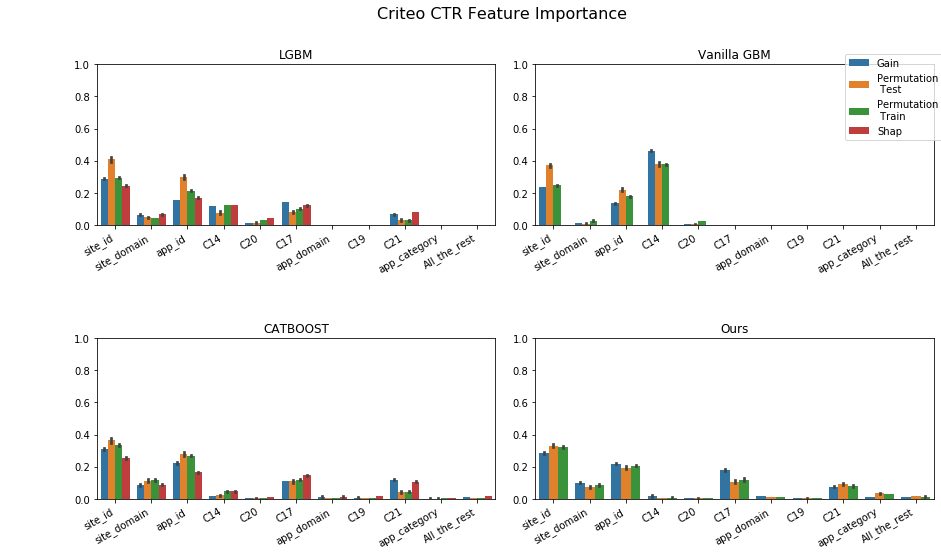

In [7]:
def paper_graph(data,title):
    models = ['LGBM', 'Vanilla GBM', 'CATBOOST', 'Ours']
    fig,a =  plt.subplots(2,2,  figsize=(15, 8))
    plt.subplots_adjust(wspace = 0.1, hspace = 0.7)
    counter = 0
    for i in range(2):
        for j in range(2):
            temp_model = models[counter]
            plot_data = data[(data.Model == temp_model)]
            plot_data[" "] = plot_data["Value"]
            plot_data = plot_data.set_index('Features')
            plot_data = plot_data.loc[feature_order,:].reset_index()
            plot_data['Features'] = plot_data['Features'].map(replace_feature_names_dict)
            ylim = 1
            a[i][j].set_title(temp_model)
            a[i][j].set_ylim(0,ylim)
            a[i][j].yaxis.set_label_coords(-0.2, 0.5)
            sns.barplot(x='Features', y=" ", hue="Feature Importance Type", data=plot_data, ax = a[i][j])
            a[i][j].set_xticklabels(a[i][j].get_xticklabels(), rotation=30, horizontalalignment='right')
            a[i][j].set_xlabel('')
            if temp_model != 'Ours':
                handles, labels = a[i][j].get_legend_handles_labels()
            a[i][j].legend_.remove()
            counter += 1
    fig.legend(handles, labels, bbox_to_anchor = [0.88,0.88])
    fig.suptitle(title, fontsize=16)
    fig.savefig(F"{title}.png")
    plt.show()
    
paper_graph(fi[fi["Feature Importance Type"] != 'Shap Train'],'Criteo CTR Feature Importance') 